# A taste of Processing Images

## Types of image data
There are two kinds main kinds of image data. 

**Vector Graphics** One kind, which we will not talk much about here,
is vector data. Vector images represent objects in an image such as shapes. A circle
is represented as an object with a center and radius. Also the visual attributes of
the circle such as the thickness of its lines, the color of the stroke (line) and
the fill. One format for vector images is Scalable Vector Graphics (SVG) format.
Matplotlib has and SVG backend. Typically you will not have SVG as data but rather
as an export format. SVG is a great way to store visual information that is
something like drawings or collections of shapes. While geographic information
is often stored differently, a map or a diagram might be well represented
as a vector image such as a SVG. This is because it doesn't need to store
each pixel, just objects like shapes and colors. 

**Raster Graphics** In raster graphics an image is an intensity for each location
in a grid. If it is a color image, then each location will typically store 3 or 4
numbers. Sometimes it will have just a red, green and blue channel. Other times
you will encounter a forth channel that represents transparency. In rare cases
if an image is going to be printed you may find other color representations
such as CMYK which is adapted for 4 kinds of ink.

When you work with satellite data or meteorological (weather data) it may be given
as a grid with more than 4 channels. These channels may be physical variables
representing quantities such as pressure, humidity, temperature or they may
be light images in "bands" beyond human vision (ultraviolet or infrared). 

No matter which kind of data you have you almost always be working with an array of data
which, at least in python, will be a numpy array. Black and white images are going to
have just rows and columns. Color images will have rows, columns and channels. Color video
will have rows, columns, channels and frames. So the shape of a 1 minute color video might be 
$(640,480,3,360)$. For now we will just focus on images.

## Libraries for working with images

You will often work with one or more of the following libraries.

### Numpy and Scipy

Scipy has a reasonable module for working with images called ndimage and the 
[api](https://docs.scipy.org/doc/scipy/reference/ndimage.html) is 

https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html

* Scipy/numpy(really basic stuff)
* pillow ( formally PIL this has lots of image formats)
* opencv (Computer vision library wrapping C/C++)
* scikit-image (simplier and less features than opencv ... focused on image processing)

There are many others. These are the most popular for plain images. If you find
yourself working with satellite images, or microscopy, for instance, you can
find more specialized libraries that can make life easier. In addition video
introduces a whole new set of challenges. For now we will work with
basic skimage and numpy for this introduction.

In [1]:
# We import skimage along with the usual suspects
import skimage
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Basic Examples

Lets start out creating a very basic random image. The important thing to note
here is that a greyscale image is just a 2-D array of numbers. Here we want to 
to represent "1" as white and "0" as black. We also want a color bar next to
the image so we can tell what colors are which.

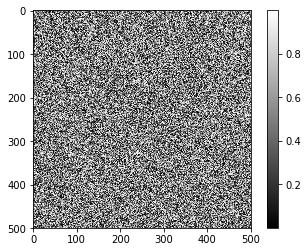

In [2]:
random_image = np.random.random((500,500))
plt.imshow(random_image, cmap='gray') 
plt.colorbar()

Note the "cmap" is the color map. We want it to go from gray to white. In the
next example we will see the default color map which is "viridis" the older
default, and one that you will see in many academic papers is "jet" a.k.a
the rainbow color map. This is a terrible color map. I mean it looks cool
but there are several reasons why it is actually almost *never* the right
thing to use. 

### Loading a Test Image

skimage has a number of test images in data. When you are just trying algorithms
or using operators, it is often useful to use a popular test image. This way
you can often compare becaus images like "cameraman" are used in lots of
documentation and many academic papers. Here we are using the coins image
because we want to see a bunch of separated blobs.

In [3]:
from skimage import data
coins = data.coins()

print("Type: ", type(coins))
print('dtype', coins.dtype)
print('shape', coins.shape)

Type:  <class 'numpy.ndarray'>
dtype uint8
shape (303, 384)


As you see here the coins image is a grayscale image because it is a simple 2-D array.
Note though that unlike our random image it is a uint8 meainging numbers from 0
to 255. uint8 means 8 bits so numbers from 0 to $2^8 - 1$, and no sign. This means
they take 8 bits or one byte per pixel to store. Knowing the type is imporatant. 
Most images you will come across will have pixel
values either as floating point number from 0 to 1 OR unit8. Be careful to know
which you are dealing with. For accurate computation you want your pixel values
usually to be double floating point images. However, that means they will be 8
times as large as if they were uint8. Some libraries only work with unit8 and some
need doubles. Make sure you pay attention to types when you do operations or else
you could see weird artifacts. Some operations on uint8 for example, cause wrap
around so that $255+1 = 0$ as crazy as that sounds. This kind of mistake is very
very common in working with images.

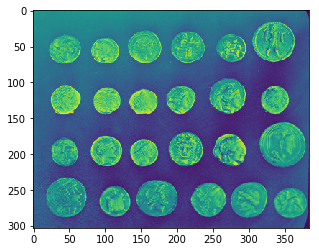

In [4]:
plt.imshow(coins) #default color map is viridis

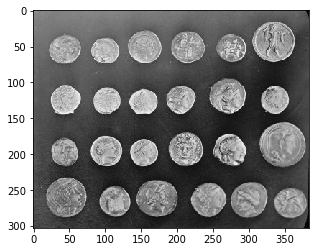

In [5]:
plt.imshow(coins,cmap='gray')

(300, 451, 3)
231 0
uint8


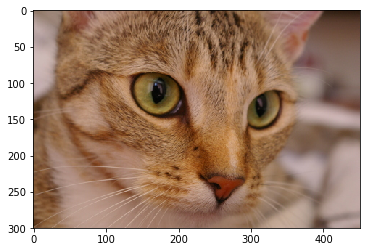

In [31]:
# Who doesn't like Kitties?!
cat = data.chelsea()
print(cat.shape)
print(cat.max(),cat.min())
print(cat.dtype)
plt.imshow(cat)

Note this is a **color** image. We know that because it has three channels
so it is a 3-D array. The last channel has index is red = 0, green=1, blue=2.
If we want just the read channel we can pull it out and turn it into
floating point numbers by dividing by the theoretical max of 255.

In [55]:
red_cat = cat[:,:,0]/255.0

### Adding noise

We can add noise random cat image. This will brighten
it (because we are adding postive numbers). It is common
to introduce noise to an image. Often you have a clean
image but you want to make sure that your algorithm is
not senstive to small changes so you add noise to make
sure this doesn't change the result.

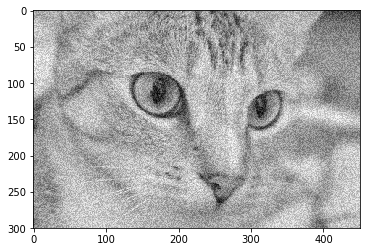

In [8]:
red_cat_shape = red_cat.shape
noise = np.random.random(red_cat_shape)*(0.3)

plt.imshow(red_cat+noise,cmap='gray')

If we had lots of noise it will make it more "white" ... brigthen the image. 
For better or worse matplotlib often scales the image back down so whatever
is the max, becomes white. If we want to make sure that anything over 1 is
white and under 0 is black we can set the max and min using vmax, and vmin:

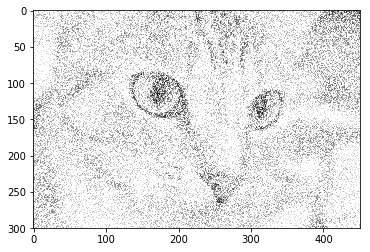

In [9]:
plt.imshow(red_cat+noise*3,cmap='gray',vmin=0,vmax=1)

For comparison here is the red channel of the cat with no noise:

(300, 451)

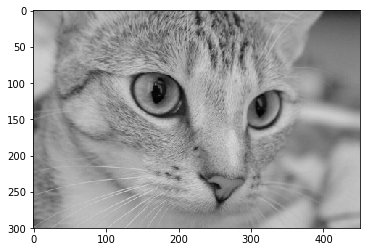

In [36]:
plt.imshow(red_cat,cmap='gray',vmin=0,vmax=1)
red_cat.shape

## Histogram

One of the best tools for image analysis is the histogram. They are very simple to compute. If you rotate an image by a little or shift by a bit, the histogram will not change. Lets calculate the histogram the "old-fashoned way" using numpy histogram. 

<BarContainer object of 256 artists>

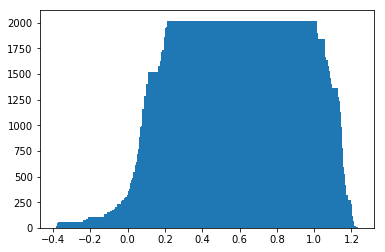

In [56]:
vals, bins = np.histogram(red_cat,bins=256)
plt.bar((bins[:-1]+bins[1:])*0.5, vals) # We need to average the left and right
# bin boundary to get the middle of the bin

Something is obviously wrong here!! There is **no way** we are going to get so many bins with the same value. Also there are no negative bins. The first guess here is that because the bins are floating point numbers, plt.bar has no idea how wide to make the bins. Let shrink them. We know that we have 256 bars from 0 to 1 so lets make the bars 1/256 wide.

<BarContainer object of 256 artists>

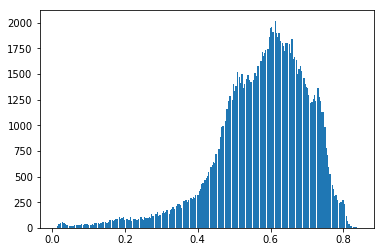

In [61]:
vals, bins = np.histogram(red_cat,bins=256)
plt.bar((bins[:-1]+bins[1:])*0.5, vals, width=1/255) 

Ok so we fixed the weird bin (no negatives) and no flat region. So the problem **was** overwide bars. However, we have another problem now. Those weird gaps mean something. Lets not ignore them:

In [51]:
vals

array([   1,    1,   16,   37,   42,    0,   58,   50,   35,   28,   28,
          0,   17,   19,   16,   22,   24,    0,   31,   25,   29,   31,
         34,    0,   25,   33,   38,   37,   26,    0,   32,   34,   32,
         43,   45,    0,   46,   40,   46,   46,   52,    0,   53,   42,
         48,   57,   76,    0,   75,   66,   74,   84,   85,    0,  102,
         89,   92,  107,   77,    0,   85,   81,   79,  107,   68,    0,
         88,   85,   75,   77,   86,    0,  104,   83,   79,  105,   93,
          0,   94,  105,   92,  132,  120,    0,  134,  133,  151,  119,
        124,    0,  143,  164,  145,  154,  173,    0,  130,  178,  183,
        203,  183,    0,  214,  232,  235,  220,  197,    0,  257,  215,
        267,  255,  274,    0,  293,  279,  304,  289,  319,    0,  317,
        359,  376,  423,  437,    0,  467,  484,  503,  547,    0,  592,
        609,  643,  636,  717,    0,  772,  768,  882,  982,  993,    0,
       1042, 1158, 1155, 1240, 1283,    0, 1243, 14

We shouldn't expect this image should have so many "0" counts on bins. Why would it go from 1425 to 0 to 1440. We could expect some zeros on the extremes but in the middle it looks suspicious. Lets look at the bins to see if they make sense. Lets see how wide the bins are. Since the image values should be 0-255 when we divide by 255 it goes from 0 to 1. The bin width should be 1/255.

In [58]:
1/(bins[1]-bins[0])

306.47887323943655

This is not good!!! If the bins are really thin and there are 256 of them, sometimes there won't be any values that land in the bins. The fix is we need to set the bins very carefully ourselves. We know the original values will be numbers from 0-255 divided by 255. So the possible image values are 0, 1/255, 2/255, ... , 255/255=1. Those should be the bin centers. The bin width is 1/255 but we need to shift by half that amount (subtract) to get the left side of the bins, and add half that amount to get the right side.

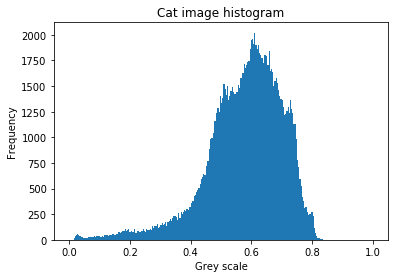

In [65]:
im_bins = (np.arange(257)/255)-(0.5*1/255) # remember if there are 256 bins there are 257 bin boundaries
vals, bins = np.histogram(red_cat,bins=im_bins)
plt.bar((bins[:-1]+bins[1:])*0.5, vals, width=1/255)
plt.title('Cat image histogram')
plt.xlabel('Grey scale')
_=plt.ylabel('Frequency')

## Image manipulations: lightening

Lightening an image typically means just adding a value to the image. The image cannot
go beyond 1 so we need to clip it at 1. Lets see how the image looks when we add .4 to
the image, and also look at the histogram.

Text(0,0.5,'Frequency')

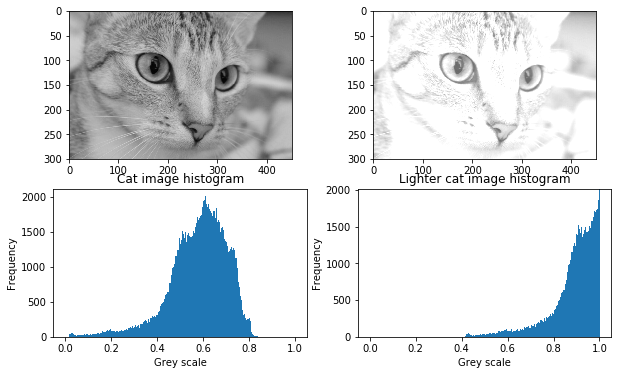

In [87]:
lighter_cat = np.clip(red_cat + 0.4,0,1)
lighter_vals, bins = np.histogram(lighter_cat,bins=im_bins)
fig, axs = plt.subplots(2,2, figsize=(10,6))
axs[0][0].imshow(red_cat, cmap='gray', vmin=0, vmax=1) #keep it from normalizing
axs[0][1].imshow(lighter_cat, cmap='gray', vmin=0, vmax=1) #keep it from normalizing
axs[1][0].bar((bins[:-1]+bins[1:])*0.5, vals, width=1/255)
axs[1][0].set_title('Cat image histogram')
axs[1][0].set_xlabel('Grey scale')
axs[1][0].set_ylabel('Frequency')
axs[1][1].bar((bins[:-1]+bins[1:])*0.5, lighter_vals, width=1/255)
axs[1][1].set_ylim(0, max(vals)) # Since so many vals are in the 1 bin
#                                  we can't see anything unless we set ylim
axs[1][1].set_title('Lighter cat image histogram')
axs[1][1].set_xlabel('Grey scale')
axs[1][1].set_ylabel('Frequency')

## Increase contrast

Now notice that when we lightened the blacks became whiter. Thats not good. Looking at the histogram we see that the lightest colors in the original image were 0.8. Lets say we want to keep the black values at 0 and just spread out the histogram, then we can multiply by 1/0.8 which will brighten the image with increasing contrast.

Text(0,0.5,'Frequency')

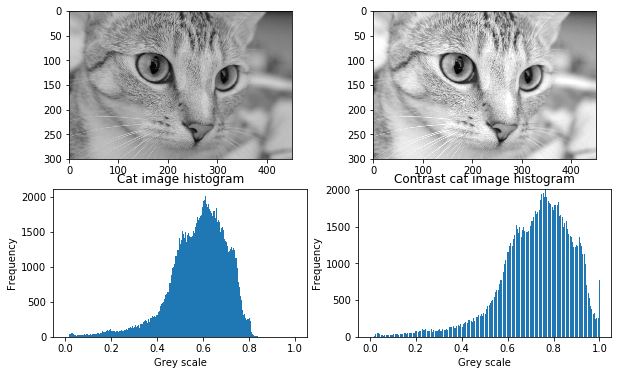

In [88]:
contrast_cat = np.clip(red_cat* (1/0.8),0,1)
contrast_vals, bins = np.histogram(contrast_cat,bins=im_bins)
fig, axs = plt.subplots(2,2, figsize=(10,6))
axs[0][0].imshow(red_cat, cmap='gray', vmin=0, vmax=1) #keep it from normalizing
axs[0][1].imshow(contrast_cat, cmap='gray', vmin=0, vmax=1) #keep it from normalizing
axs[1][0].bar((bins[:-1]+bins[1:])*0.5, vals, width=1/255)
axs[1][0].set_title('Cat image histogram')
axs[1][0].set_xlabel('Grey scale')
axs[1][0].set_ylabel('Frequency')
axs[1][1].bar((bins[:-1]+bins[1:])*0.5, contrast_vals, width=1/255)
axs[1][1].set_ylim(0, max(vals)) # Since so many vals are in the 1 bin
#                                  we can't see anything unless we set ylim
axs[1][1].set_title('Contrast cat image histogram')
axs[1][1].set_xlabel('Grey scale')
axs[1][1].set_ylabel('Frequency')

In the contrasty image the histogram also has gaps but these are ok. In this case when we strech out the histogram we know we are going to create gaps ... that is expected. You can now see that the black are still full black but now the whites are full white.

## Thresholds and segmentation

The goal here is to play a bit with the coins image to see if we can separate the background from the coins. Lets start by looking at the coins image.

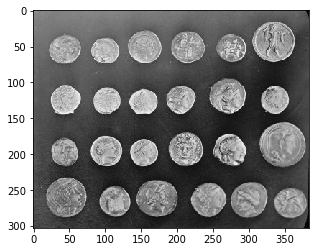

In [90]:
plt.imshow(coins, cmap='gray')

Lets compute the histogram here too but this time lets use the matplotlib to do it. To do
that we need to make the image a 1-D array with the ravel command.

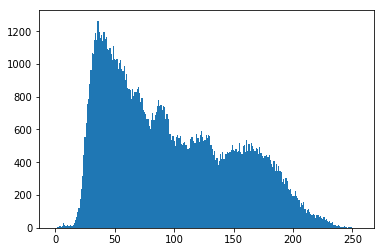

In [95]:
coins_bins = (np.arange(257)-0.5) # this goes from 0 to 255 not 0 to 1.
coins_vals_bins = plt.hist(coins.ravel(),bins=coins_bins )

We can try to separate background from foreground by thresholding declaring all values
brighter than a certain value "coins" and less than that value "backgrond". Lets try
some value and see how it works. Guessing from the histogram above we might say it starts
to get interesting at 40.

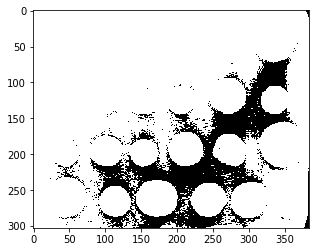

In [18]:
plt.imshow(coins>40, cmap='gray')

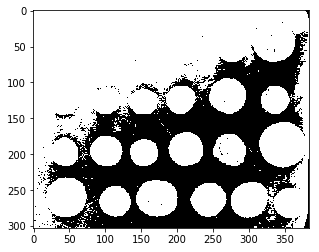

In [19]:
plt.imshow(coins>60, cmap='gray')

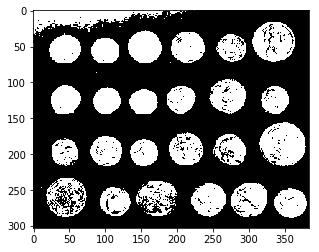

In [20]:
plt.imshow(coins>120, cmap='gray')

So thresholding gives us a problem. If we make the threshold too high, then we get more of the background but some of the inside of the coin is lost. On the other hand, if we make the threshold too low, lots of background is classified as foreground.

## Blurring an image

One thing that can help is blurring the image. If we use a gaussian filter to blure the image then small variations will get averaged out. The inside of the coin won't have those little bumps but a more uniform color. We can do that with a filter. Lets first try a gaussian filter and see how the image looks.

max=0.7559507720989699, min=0.06286093928377381


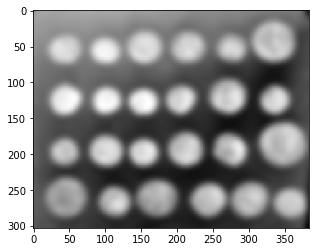

In [100]:
blurred_image = skimage.filters.gaussian(coins,sigma=5)
plt.imshow(blurred_image, cmap='gray')
print('max={}, min={}'.format(blurred_image.max(),blurred_image.min()))

Lets check the histogram again, note that our image is now 0-1 so our bins need to be divided by 1/255.

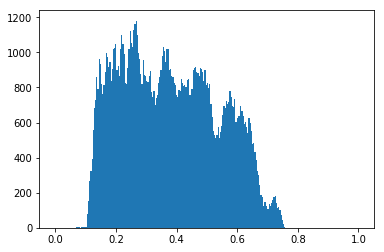

In [101]:
coins_vals_bins = plt.hist(blurred_image.ravel(),bins=coins_bins*(1/255.) )

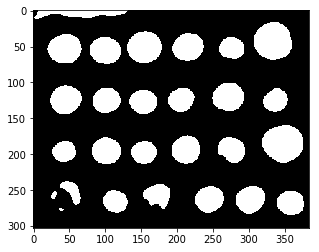

In [103]:
plt.imshow(blurred_image>0.5, cmap='gray')

This is cleaner but still a bit weird. Also why 0.5? One of the issue is that by using a gaussian filter we smoothed the edges. Lets use a filter which tries to keep the edges sharp while averageing: A median filter.

max=231, min=5


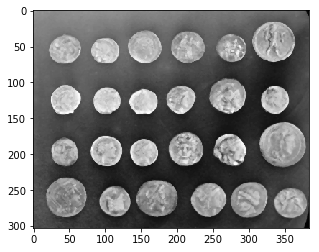

In [105]:
median_image = skimage.filters.median(coins)
plt.imshow(median_image, cmap='gray')
print('max={}, min={}'.format(median_image.max(),median_image.min()))

We can make the blur bigger to do more smoothing.

max=202, min=9


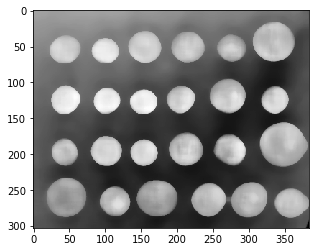

In [115]:
median_image = skimage.filters.median(coins, selem=np.ones((15,15)))
plt.imshow(median_image, cmap='gray')
print('max={}, min={}'.format(median_image.max(),median_image.min()))

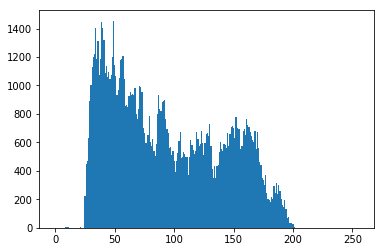

In [112]:
coins_vals_bins = plt.hist(median_image.ravel(),bins=coins_bins )

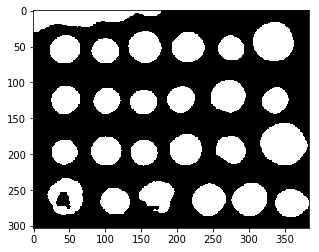

In [116]:
plt.imshow(median_image>120, cmap='gray')

Thats probably as good as were going to get without working pretty hard. We could try local histogram equalization. We could use an actual segmentation algorithm like watershed. 

## Edges

Suppose we want to find the edges of the coins. The edges are a place where the derivative of the coin is large. In other words we want to look at the changes in the pixel values from one pixel to the next and see where it change. If we want to find the change at a pixel we need to look at the difference 1 to the left and one to the right. The skip is then 2.

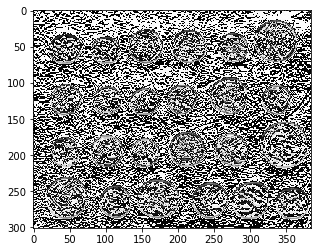

In [118]:
dx_coins = coins[2:,:]-coins[:-2,:]
plt.imshow(dx_coins,cmap='gray')

The problem here is that any little change is magnafied. We need to supress the little change due to noise and texture in the image and only look at the wide change. Lets use the median filtered image.

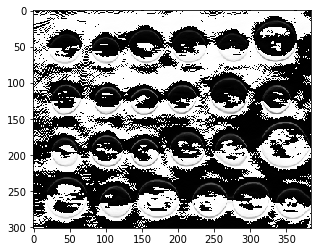

In [120]:
dx_median_coins = median_image[2:,:]-median_image[:-2,:]
plt.imshow(dx_median_coins,cmap='gray')

Lets see if blurring is any better.

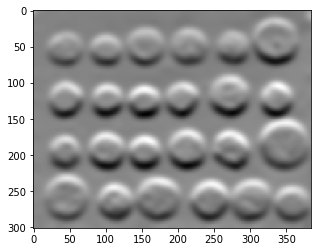

In [122]:
dx_bcoins = blurred_image[2:,:]-blurred_image[:-2,:]
plt.imshow(dx_bcoins,cmap='gray')

This shows us where there is a change in the vertical direction but we don't care if it is vertical or horizontal. Thus we compute the sum of squares to get the magnitude of the gradient edge filter.

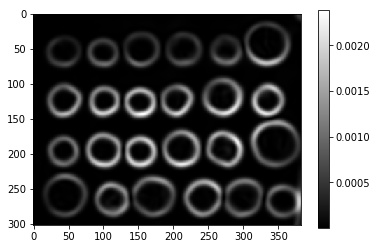

In [124]:
xbcoins = (blurred_image[1:,1:]-blurred_image[:-1,1:])**2 + (blurred_image[1:,1:]-blurred_image[1:,:-1])**2
plt.imshow(xbcoins,cmap='gray')
plt.colorbar()

Again we can threshold to get the edges. This isn't going to be quite good enough but hopefully you get the idea at this point. Please try different sklearn filters to play around.

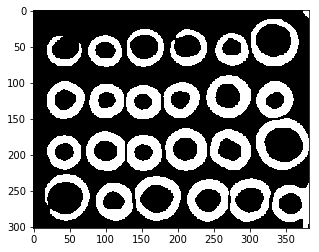

In [126]:
plt.imshow(xbcoins>0.00025,cmap='gray')